### Úkol 1 část první

Funkce pro načtení, filtraci a analýzu EKG signálů

In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

DRIVE_DB = 'stress-recognition-in-automobile-drivers-1.0.0'
CHARIS_DB = 'charis-database-1.0.0'

def centrovat(signal):
    return signal - np.mean(signal)

def rc_horni_propust(signal, fs, fc=0.5):
    rc = 1.0 / (2.0 * np.pi * fc)
    dt = 1.0 / fs
    a = rc / (rc + dt)
    y = np.zeros(len(signal))
    for i in range(1, len(signal)):
        y[i] = a * (y[i - 1] + signal[i] - signal[i - 1])
    return y

def fft_odstraneni_driftu(signal, fs, mezni=0.5):
    spektrum = fft(signal)
    frekvence = np.fft.fftfreq(len(signal), 1.0 / fs)
    spektrum[np.abs(frekvence) < mezni] = 0
    return np.real(ifft(spektrum))

def nacist_ekg(databaze, jmeno, kanal=0, max_sekund=300):
    cesta = os.path.join(databaze, jmeno)
    hlavicka = wfdb.rdheader(cesta)
    spf = hlavicka.samps_per_frame if hlavicka.samps_per_frame else [1] * hlavicka.n_sig
    limit = min(hlavicka.sig_len, int(max_sekund * hlavicka.fs) + 1)

    if spf[kanal] > 1:
        zaznam = wfdb.rdrecord(cesta, sampto=limit, smooth_frames=False, channels=[kanal])
        if zaznam.e_p_signal is not None:
            data = np.array(zaznam.e_p_signal).flatten()
        else:
            data = zaznam.p_signal[:, 0].flatten()
        efektivni_fs = len(data) / (limit / hlavicka.fs)
    else:
        zaznam = wfdb.rdrecord(cesta, sampto=limit, channels=[kanal])
        data = zaznam.p_signal[:, 0].flatten()
        efektivni_fs = float(hlavicka.fs)

    data = centrovat(data)
    if abs(np.min(data)) > abs(np.max(data)):
        data = -data
    data = rc_horni_propust(data, efektivni_fs, fc=0.5)
    return data, efektivni_fs

def detekovat_r_piky(signal, fs, percentil=97, min_vzdalenost_s=0.35):
    kladny = np.maximum(signal, 0)
    energie = kladny ** 2
    prah = np.percentile(energie, percentil)
    min_vzd = int(min_vzdalenost_s * fs)
    nalezene = []
    nad_prahem = False
    max_val = -np.inf
    max_idx = 0

    for i in range(len(energie)):
        if energie[i] > prah:
            if not nad_prahem or energie[i] > max_val:
                max_val = energie[i]
                max_idx = i
            nad_prahem = True
        else:
            if nad_prahem:
                if len(nalezene) == 0 or (max_idx - nalezene[-1]) >= min_vzd:
                    nalezene.append(max_idx)
                nad_prahem = False
                max_val = -np.inf

    return np.array(nalezene)

def spocitat_bpm(r_piky, fs, okno_s=15):
    if len(r_piky) < 2:
        return []
    celk_cas = r_piky[-1] / fs
    pocet_oken = int(celk_cas // okno_s)
    bpm = []
    for i in range(pocet_oken):
        start = i * okno_s * fs
        konec = (i + 1) * okno_s * fs
        pocet = np.sum((r_piky >= start) & (r_piky < konec))
        bpm.append(pocet * 60.0 / okno_s)
    return bpm

def graf_bpm(bpm_hodnoty, nazev, okno_s=15):
    t = [i * okno_s / 60.0 for i in range(len(bpm_hodnoty))]
    plt.figure(figsize=(12, 5))
    plt.plot(t, bpm_hodnoty, 'b-', linewidth=1.5)
    plt.fill_between(t, bpm_hodnoty, alpha=0.15, color='blue')
    plt.title(f'Tepová frekvence – {nazev}', fontsize=14)
    plt.xlabel('Čas [min]', fontsize=12)
    plt.ylabel('BPM', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def graf_ekg_detail(signal, fs, r_piky, nazev, od=0, do=10):
    idx_od = int(od * fs)
    idx_do = int(do * fs)
    cas = np.arange(idx_od, idx_do) / fs
    maska = (r_piky >= idx_od) & (r_piky < idx_do)

    plt.figure(figsize=(14, 4))
    plt.plot(cas, signal[idx_od:idx_do], 'b-', linewidth=0.5)
    if np.any(maska):
        plt.scatter(r_piky[maska] / fs, signal[r_piky[maska]], color='red', s=40, zorder=5)
    plt.title(f'EKG – {nazev} ({od}–{do} s)', fontsize=13)
    plt.xlabel('Čas [s]')
    plt.ylabel('Amplituda')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def graf_spektrum(signal, fs, nazev):
    n = len(signal)
    frekvence = np.fft.rfftfreq(n, 1.0 / fs)
    spektrum = np.abs(np.fft.rfft(signal)) / n
    maska_f = frekvence <= 10
    f = frekvence[maska_f]
    s = spektrum[maska_f]

    plt.figure(figsize=(12, 4))
    plt.plot(f, s, 'b-', linewidth=0.8)
    plt.fill_between(f, s, alpha=0.15, color='blue')
    maska_hf = (f >= 0.5) & (f <= 3.0)
    if np.any(maska_hf):
        f_band, s_band = f[maska_hf], s[maska_hf]
        idx_peak = np.argmax(s_band)
        f_peak = f_band[idx_peak]
        f_half = f_peak / 2
        if f_half >= 0.5:
            df = f_band[1] - f_band[0]
            okno = max(1, int(0.1 * f_half / df))
            idx_h = np.argmin(np.abs(f_band - f_half))
            lo, hi = max(0, idx_h - okno), min(len(s_band), idx_h + okno + 1)
            if np.max(s_band[lo:hi]) > 0.25 * s_band[idx_peak]:
                idx_peak = lo + np.argmax(s_band[lo:hi])
                f_peak = f_band[idx_peak]
        bpm_peak = f_peak * 60
        plt.axvline(f_peak, color='red', ls='--', alpha=0.7,
                     label=f'Dominantní f = {f_peak:.2f} Hz (~{bpm_peak:.0f} BPM)')
        plt.legend(fontsize=10)
    plt.title(f'Frekvenční spektrum EKG – {nazev}', fontsize=13)
    plt.xlabel('Frekvence [Hz]')
    plt.ylabel('Amplituda')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Zpracování EKG signálů a výpočet tepové frekvence


drive02 | Fs=496 Hz | R-píky: 137 | Průměr BPM: 68.6


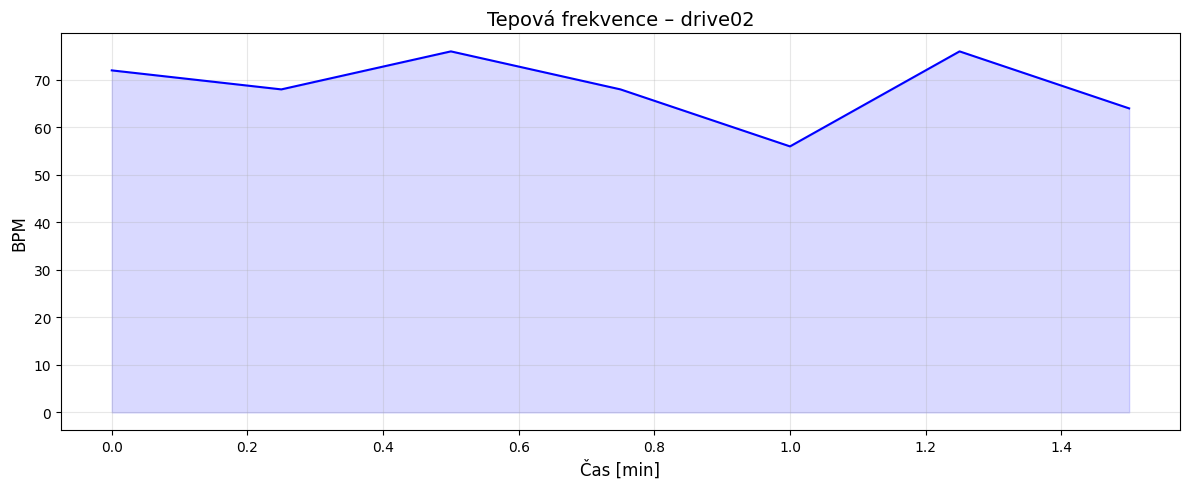

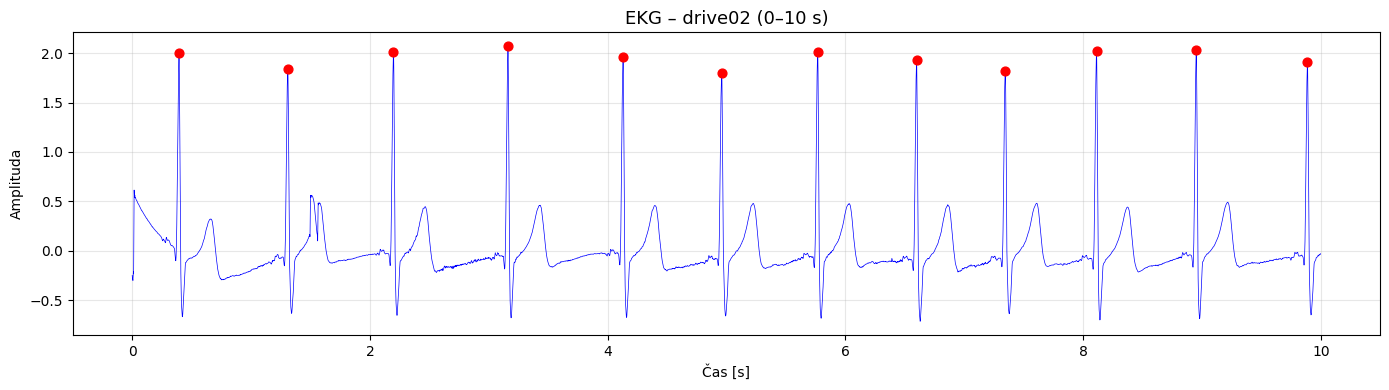

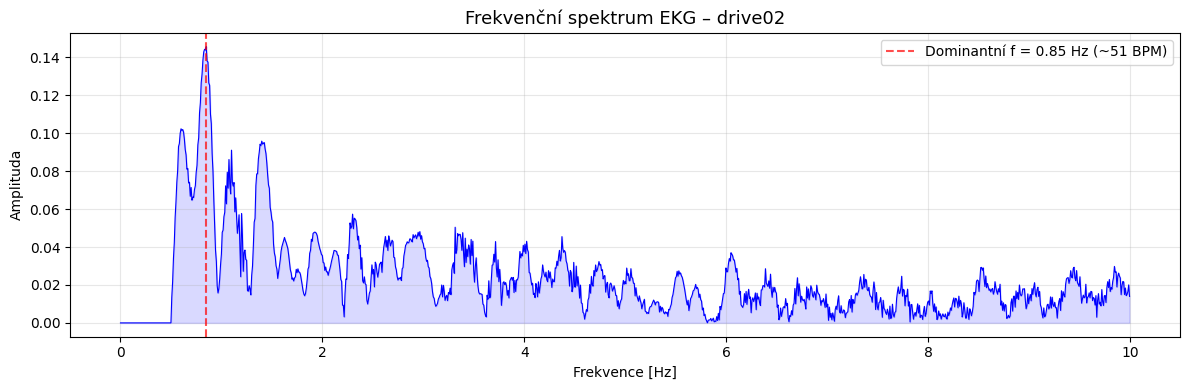


drive07 | Fs=496 Hz | R-píky: 159 | Průměr BPM: 80.6


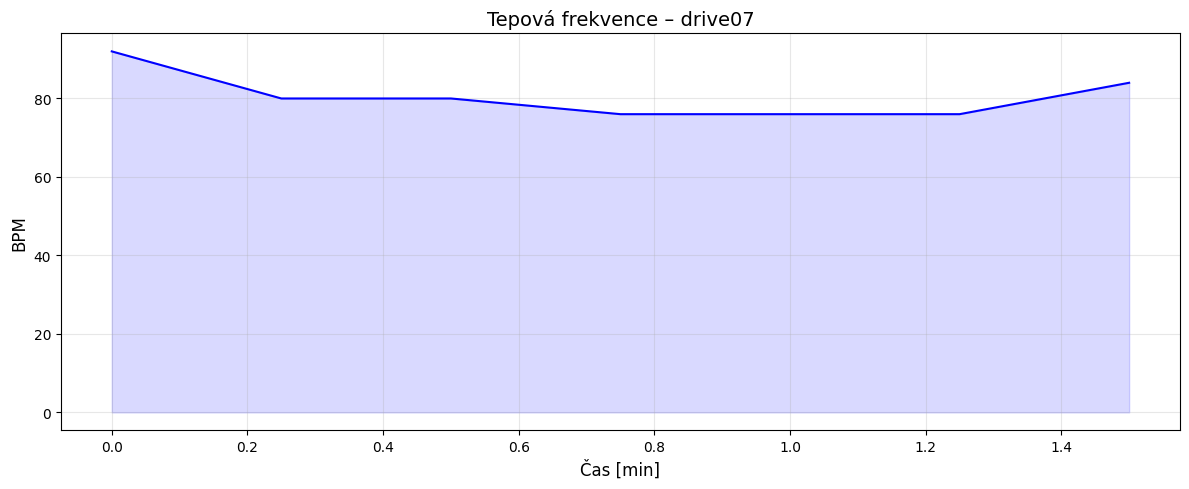

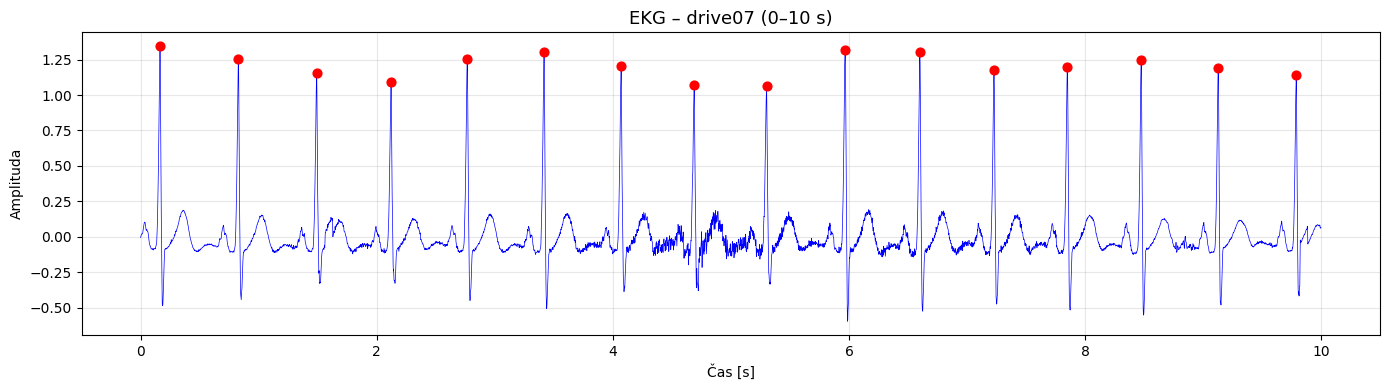

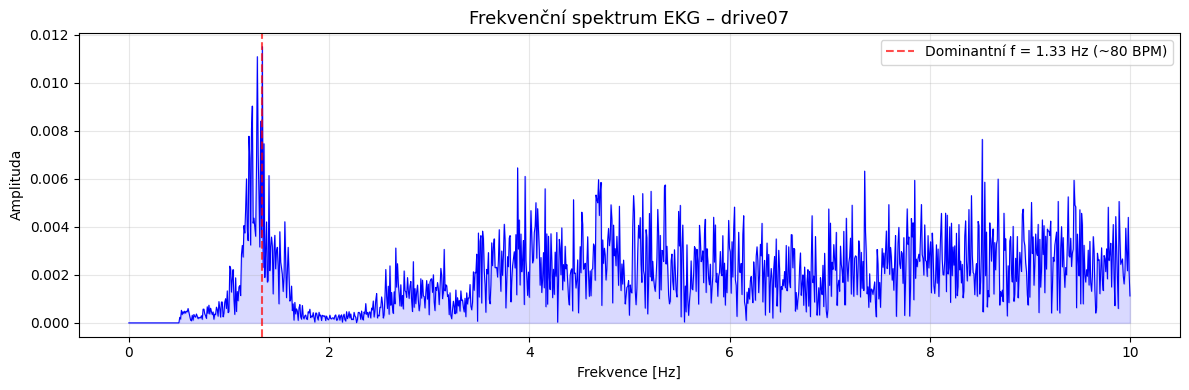


drive13 | Fs=496 Hz | R-píky: 163 | Průměr BPM: 81.7


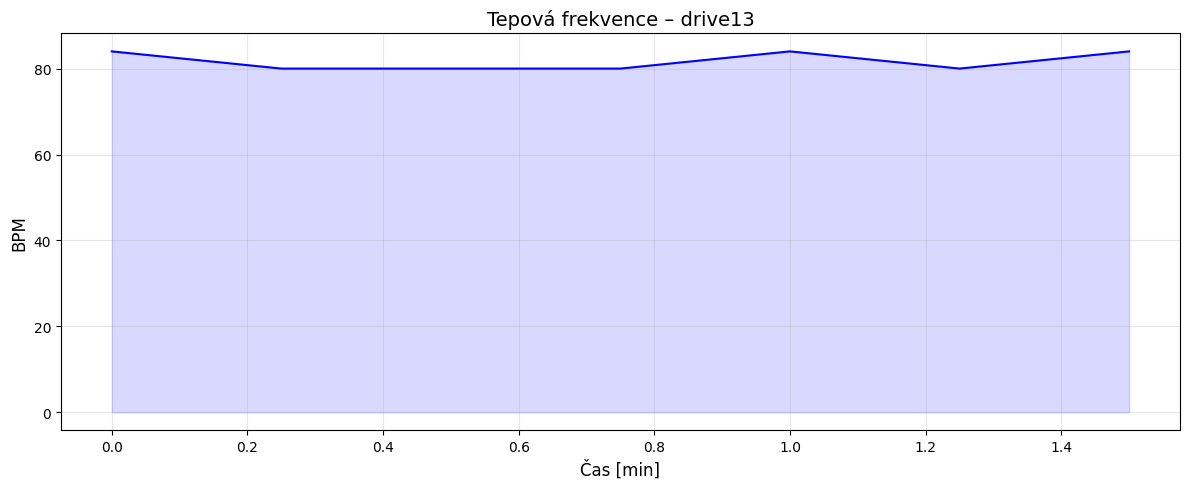

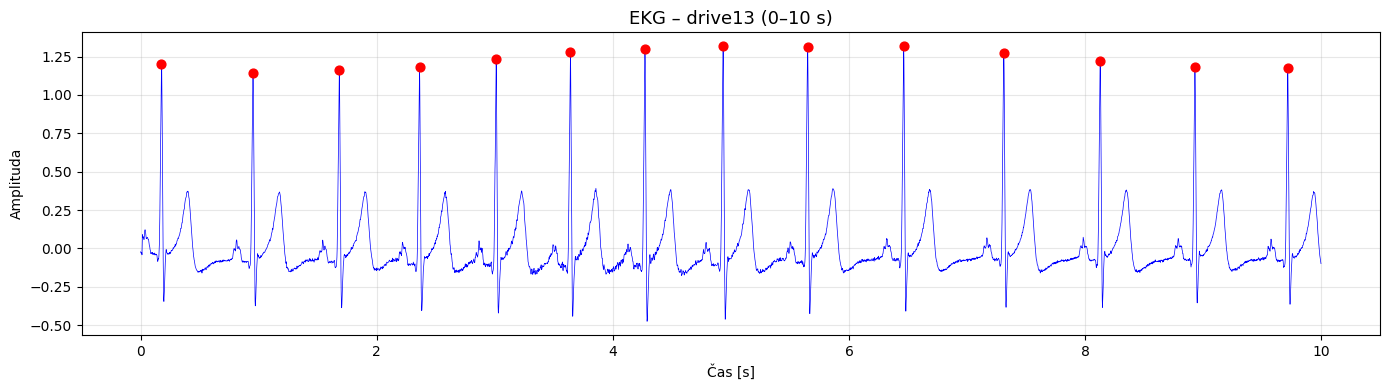

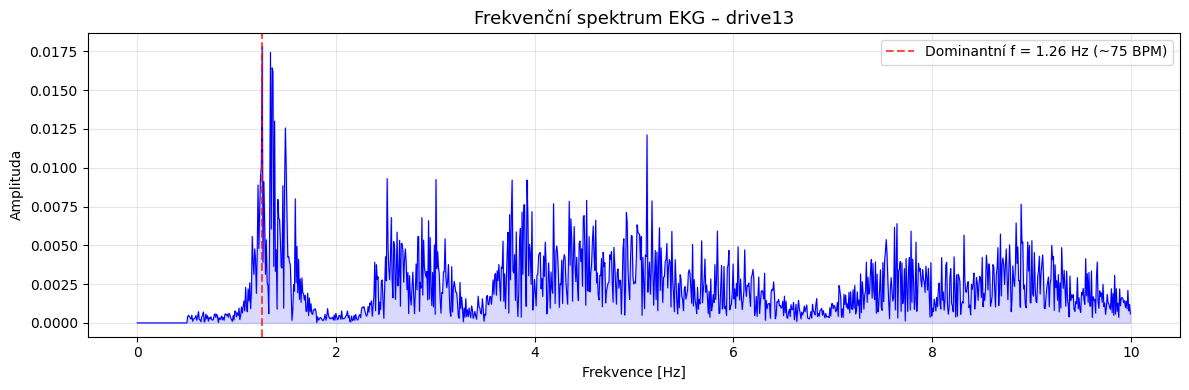


charis1 | Fs=50 Hz | R-píky: 179 | Průměr BPM: 89.7


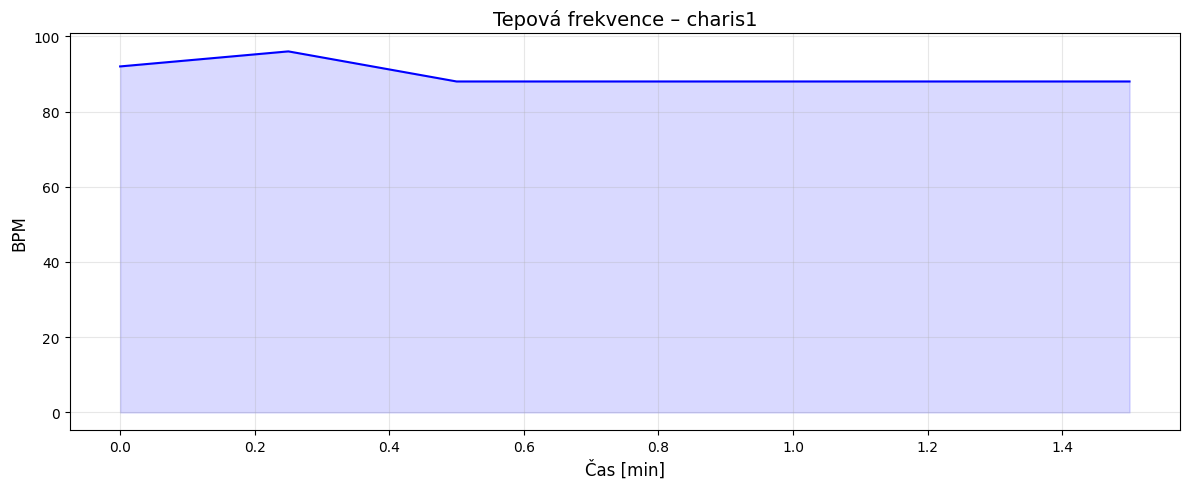

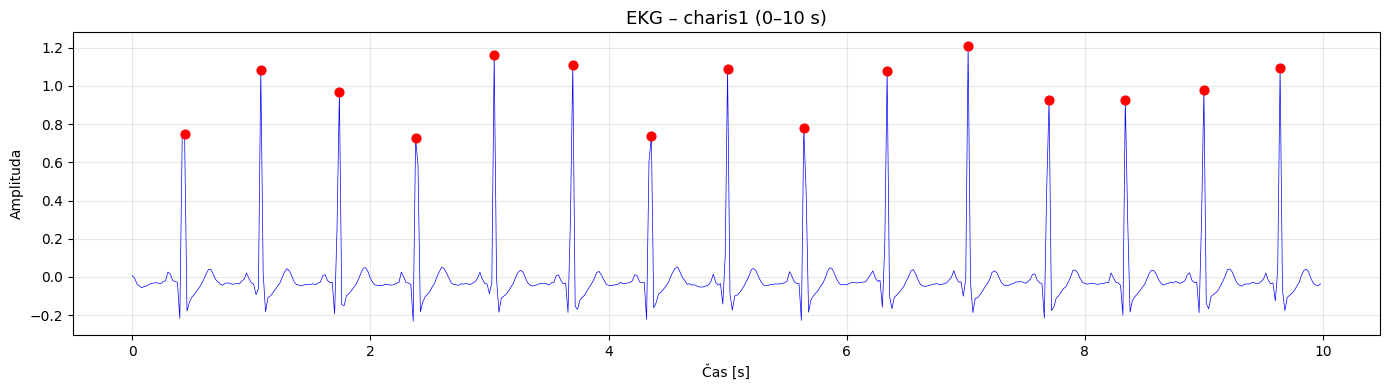

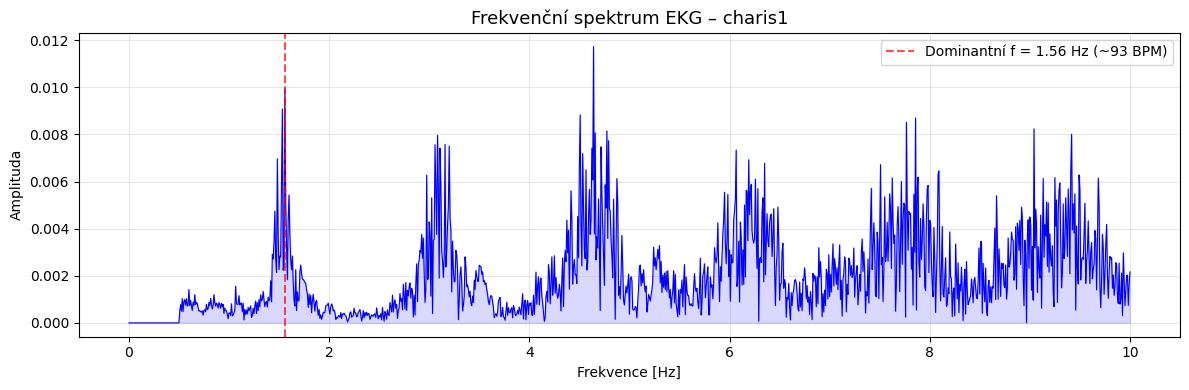


charis2 | Fs=50 Hz | R-píky: 180 | Průměr BPM: 89.7


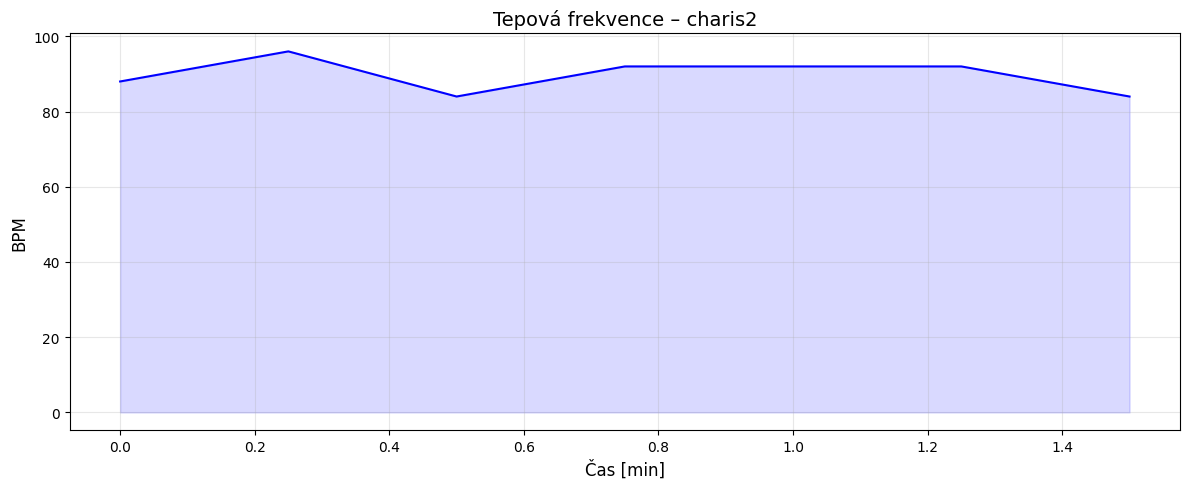

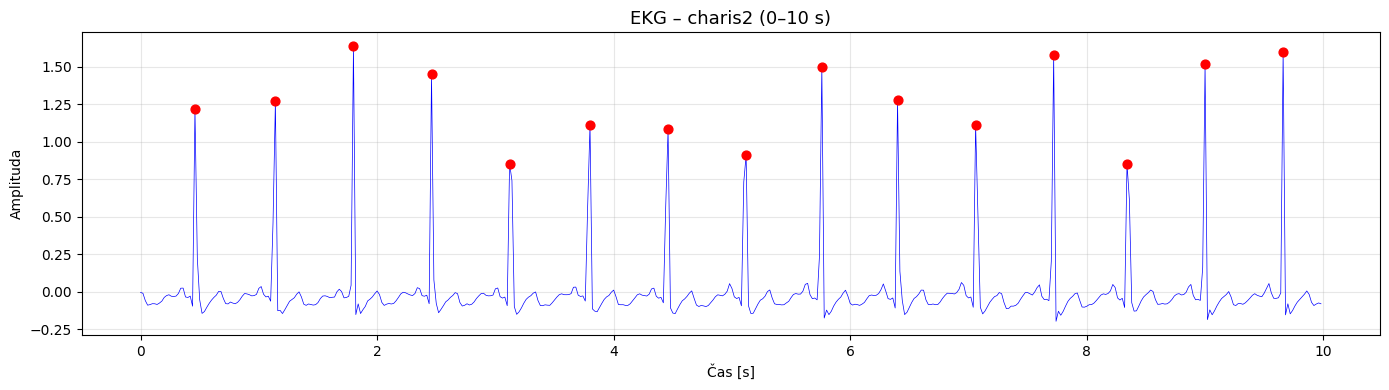

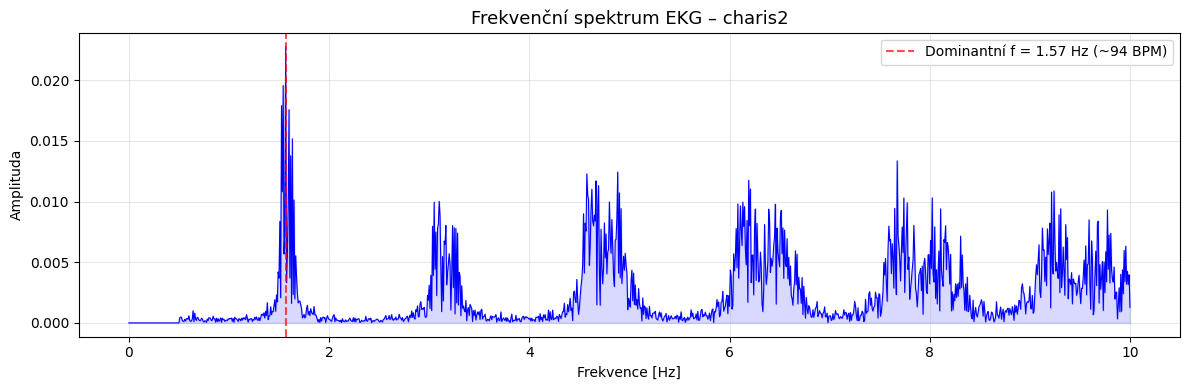


charis3 | Fs=50 Hz | R-píky: 172 | Průměr BPM: 86.3


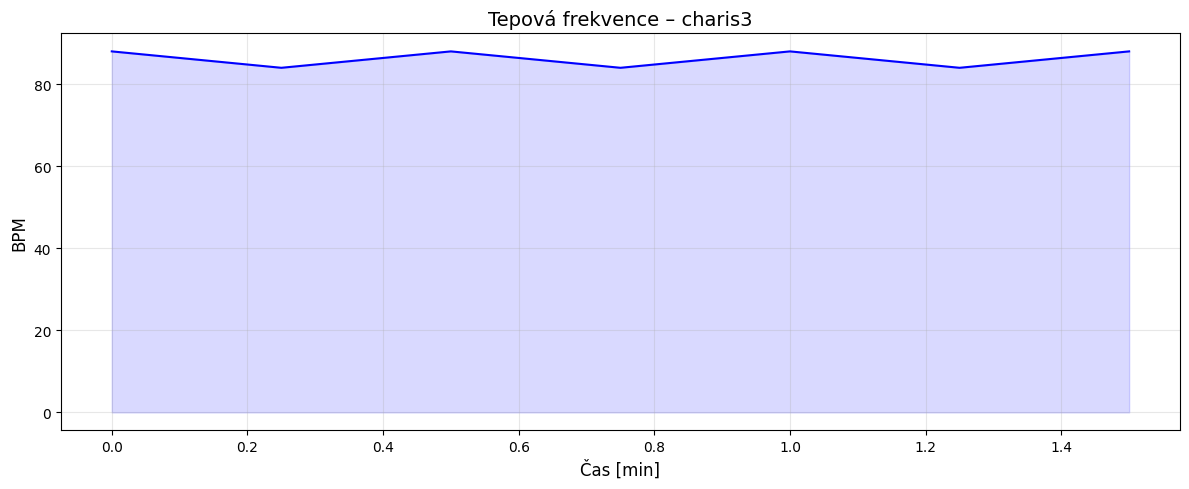

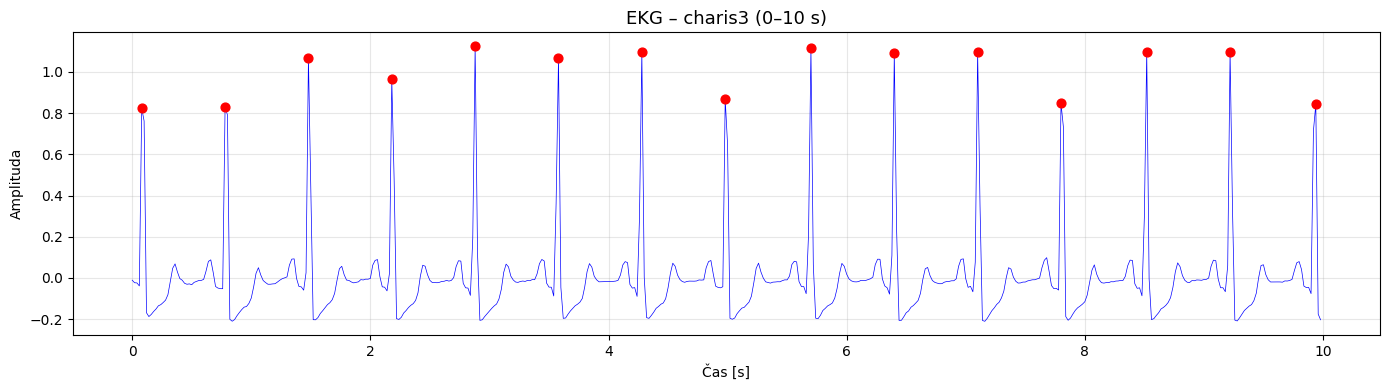

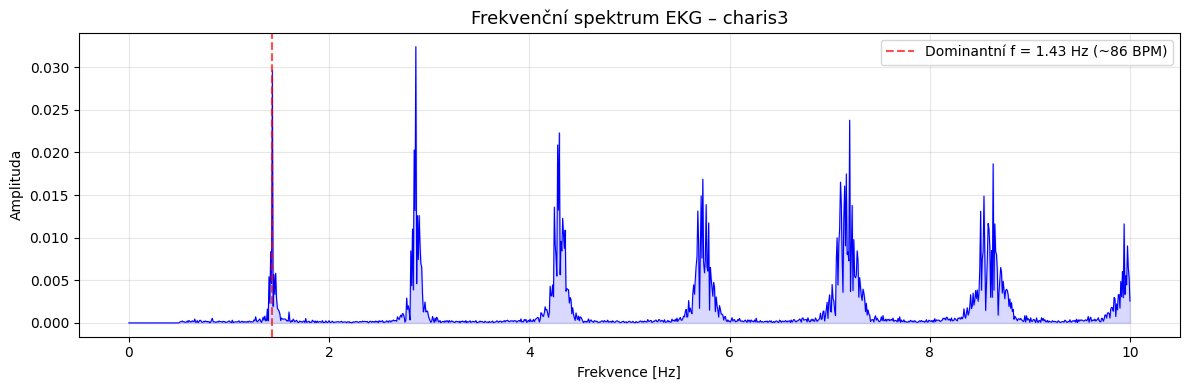



Souhrnná tabulka:
  Záznam Databáze Fs [Hz]  Počet R-píků  Průměr BPM
 drive01  DriveDB     496           177        88.6
 drive02  DriveDB     496           137        68.6
 drive03  DriveDB     496           152        74.9
 drive04  DriveDB     496           129        64.0
 drive05  DriveDB     496           141        71.4
 drive06  DriveDB     496           167        84.6
 drive07  DriveDB     496           159        80.6
 drive08  DriveDB     496           125        62.9
 drive09  DriveDB     496           148        74.9
 drive10  DriveDB     496           149        73.7
 drive11  DriveDB     496           137        69.7
 drive12  DriveDB     356           119        59.4
 drive13  DriveDB     496           163        81.7
 drive14  DriveDB     496           163        81.7
 drive15  DriveDB     480           137        69.1
 drive16  DriveDB     496           167        83.0
drive17a  DriveDB     480           139        69.7
drive17b  DriveDB     496           149     

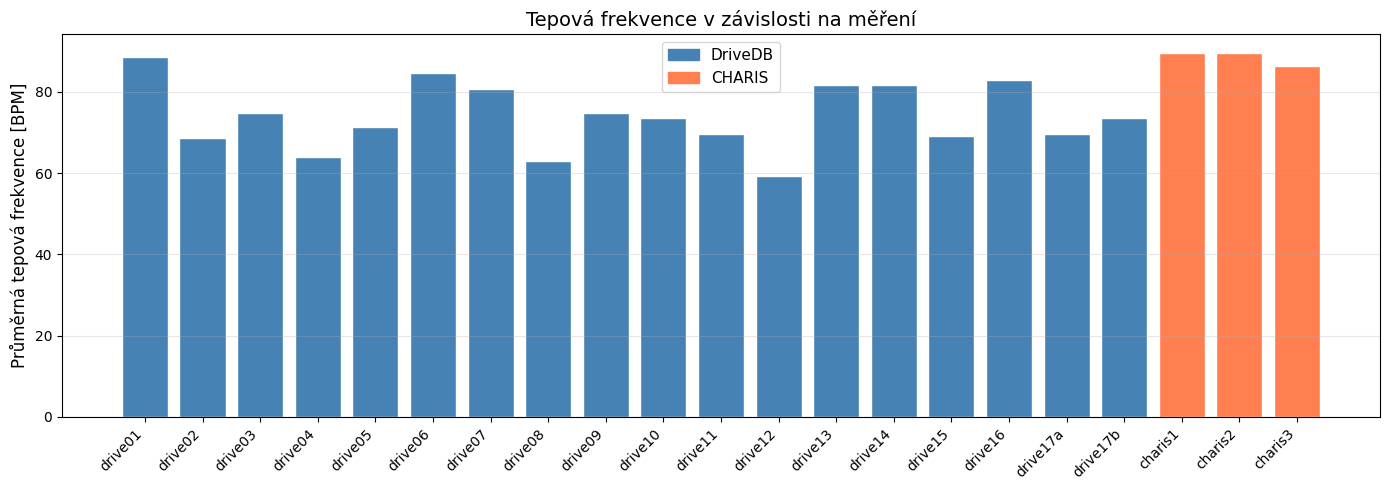

In [3]:
vse_drive = ['drive01','drive02','drive03','drive04','drive05','drive06',
             'drive07','drive08','drive09','drive10','drive11','drive12',
             'drive13','drive14','drive15','drive16','drive17a','drive17b']

ukazka_drive = ['drive02', 'drive07', 'drive13']
ukazka_charis = ['charis1', 'charis2', 'charis3']

souhrn = []

for db, zaznamy, ch, db_nazev in [
    (DRIVE_DB, vse_drive, 0, 'DriveDB'),
    (CHARIS_DB, ukazka_charis, 1, 'CHARIS')]:

    for nazev in zaznamy:
        try:
            ekg, fs = nacist_ekg(db, nazev, kanal=ch, max_sekund=120)
        except Exception as e:
            print(f"  {nazev}: chyba při načítání – {e}")
            continue

        if len(ekg) > 6_000_000:
            ekg = ekg[:6_000_000]

        ekg = fft_odstraneni_driftu(ekg, fs, mezni=0.5)
        piky = detekovat_r_piky(ekg, fs)
        bpm = spocitat_bpm(piky, fs, okno_s=15)
        prumer_bpm = np.mean(bpm) if bpm else 0

        souhrn.append({
            'Záznam': nazev,
            'Databáze': db_nazev,
            'Fs [Hz]': f'{fs:.0f}',
            'Počet R-píků': len(piky),
            'Průměr BPM': round(prumer_bpm, 1)
        })

        # detailní grafy jen pro vybrané záznamy
        zobrazit = (db_nazev == 'DriveDB' and nazev in ukazka_drive) or db_nazev == 'CHARIS'
        if zobrazit:
            print(f"\n{nazev} | Fs={fs:.0f} Hz | R-píky: {len(piky)} | Průměr BPM: {prumer_bpm:.1f}")
            graf_bpm(bpm, nazev)
            graf_ekg_detail(ekg, fs, piky, nazev)
            graf_spektrum(ekg, fs, nazev)

print("\n\nSouhrnná tabulka:")
df_souhrn = pd.DataFrame(souhrn)
print(df_souhrn.to_string(index=False))

# souhrnný graf – průměrné BPM pro každé měření
barvy_souhrn = ['steelblue' if r['Databáze'] == 'DriveDB' else 'coral' for r in souhrn]
plt.figure(figsize=(14, 5))
plt.bar(range(len(souhrn)), [r['Průměr BPM'] for r in souhrn], color=barvy_souhrn, edgecolor='white')
plt.xticks(range(len(souhrn)), [r['Záznam'] for r in souhrn], rotation=45, ha='right')
plt.ylabel('Průměrná tepová frekvence [BPM]', fontsize=12)
plt.title('Tepová frekvence v závislosti na měření', fontsize=14)
plt.grid(axis='y', alpha=0.3)
# legenda
from matplotlib.patches import Patch
plt.legend(handles=[Patch(color='steelblue', label='DriveDB'),
                    Patch(color='coral', label='CHARIS')], fontsize=11)
plt.tight_layout()
plt.show()

Validace algoritmu na MIT-BIH db


Validace na MIT-BIH Normal Sinus Rhythm Database:
Záznam  Správně  Špatně  Ref. celkem  Detekováno  Úspěšnost (%)  BPM (anotace)  BPM (odhad)
 16265     1275      16         1291        1288          98.76           99.2         99.0
 16272      824       2          826         953          99.76           63.4         73.2
 16273     1232       2         1234        1232          99.84           94.7         94.6
 16420     1146       4         1150        1149          99.65           88.3         88.3
 16483     1164       2         1166        1166          99.83           89.5         89.5
 16539     1084       1         1085        1087          99.91           83.3         83.5
 16773      991       0          991         991         100.00           76.1         76.1
 16786      958       2          960         958          99.79           73.8         73.6
 16795      942       5          947         946          99.47           72.7         72.6
 17052     1116       0      

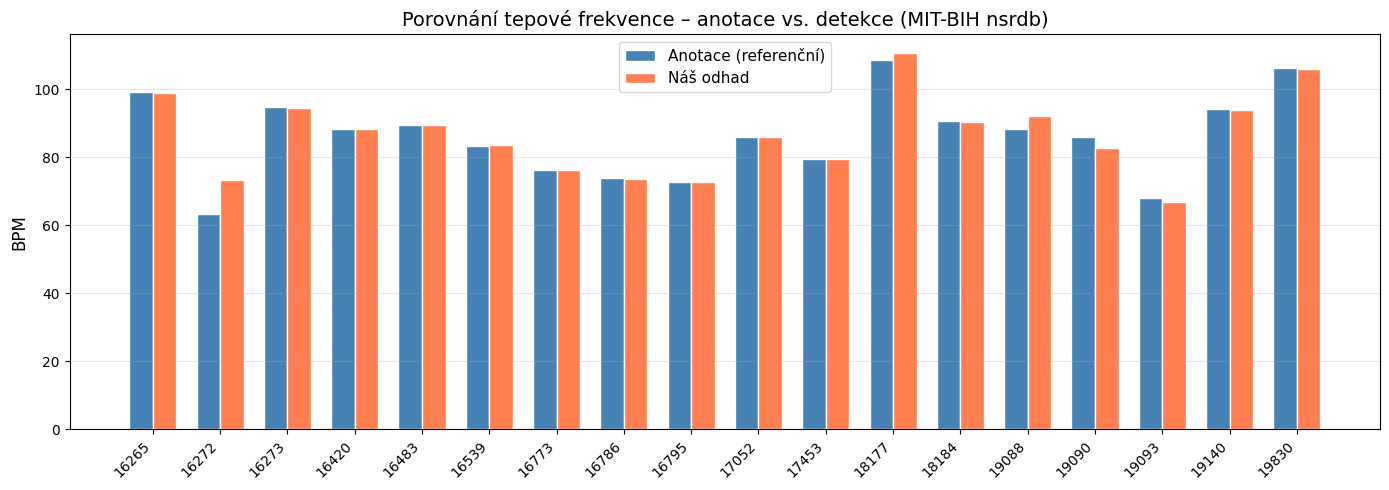

In [4]:
NSRDB = 'mit-bih-normal-sinus-rhythm-database-1.0.0'

def porovnat_piky(ref_piky, det_piky, tolerance):
    if len(det_piky) == 0:
        return 0, len(ref_piky), len(ref_piky), 0
    spravne = 0
    pouzite = np.zeros(len(det_piky), dtype=bool)
    for rp in ref_piky:
        vzdalenosti = np.abs(det_piky.astype(int) - int(rp))
        vzdalenosti[pouzite] = tolerance + 1
        min_idx = np.argmin(vzdalenosti)
        if vzdalenosti[min_idx] <= tolerance:
            spravne += 1
            pouzite[min_idx] = True
    return spravne, len(ref_piky) - spravne, len(ref_piky), len(det_piky)

BEAT_TYPY = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']

def bpm_z_piku(piky, fs):
    if len(piky) < 2:
        return 0.0
    rr = np.diff(piky) / fs
    return 60.0 / np.mean(rr)

def validace_mit_bih(nazev_zaznamu, od=0, pocet=100000, tol_ms=140):
    cesta = os.path.join(NSRDB, nazev_zaznamu)
    sig, meta = wfdb.rdsamp(cesta, sampfrom=od, sampto=od + pocet)
    ann = wfdb.rdann(cesta, 'atr', sampfrom=od, sampto=od + pocet)

    fs = meta['fs']
    tol = int(tol_ms / 1000 * fs)

    maska = np.array([s in BEAT_TYPY for s in ann.symbol])
    ref_piky = ann.sample[maska] - od

    ekg = sig[:, 0].flatten().astype(float)
    ekg = centrovat(ekg)
    ekg = fft_odstraneni_driftu(ekg, fs)
    detekovane = detekovat_r_piky(ekg, fs)

    ok, spatne, ref_n, det_n = porovnat_piky(ref_piky, detekovane, tol)
    ref_bpm = bpm_z_piku(ref_piky, fs)
    det_bpm = bpm_z_piku(detekovane, fs)
    return ok, spatne, ref_n, det_n, ref_bpm, det_bpm

with open(os.path.join(NSRDB, 'RECORDS')) as f:
    test_zaznamy = [r.strip() for r in f if r.strip()]

radky = []
celkem_ok = 0
celkem_ref = 0

for z in test_zaznamy:
    ok, spatne, ref_n, det_n, ref_bpm, det_bpm = validace_mit_bih(z)
    uspesnost = (ok / ref_n * 100) if ref_n > 0 else 0
    celkem_ok += ok
    celkem_ref += ref_n
    radky.append([z, ok, spatne, ref_n, det_n, round(uspesnost, 2),
                  round(ref_bpm, 1), round(det_bpm, 1)])

df_validace = pd.DataFrame(radky, columns=[
    'Záznam', 'Správně', 'Špatně', 'Ref. celkem', 'Detekováno',
    'Úspěšnost (%)', 'BPM (anotace)', 'BPM (odhad)'])
celk_uspesnost = celkem_ok / celkem_ref * 100 if celkem_ref > 0 else 0

print("\nValidace na MIT-BIH Normal Sinus Rhythm Database:")
print(df_validace.to_string(index=False))
print(f"\nCelková úspěšnost detekce: {celk_uspesnost:.2f}%")

# Graf porovnání BPM – anotace vs náš odhad
nazvy = df_validace['Záznam'].tolist()
bpm_ref = df_validace['BPM (anotace)'].tolist()
bpm_det = df_validace['BPM (odhad)'].tolist()
x = np.arange(len(nazvy))
sirka = 0.35

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x - sirka/2, bpm_ref, sirka, label='Anotace (referenční)', color='steelblue', edgecolor='white')
ax.bar(x + sirka/2, bpm_det, sirka, label='Náš odhad', color='coral', edgecolor='white')
ax.set_xticks(x)
ax.set_xticklabels(nazvy, rotation=45, ha='right')
ax.set_ylabel('BPM', fontsize=12)
ax.set_title('Porovnání tepové frekvence – anotace vs. detekce (MIT-BIH nsrdb)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Úkol 2 – Výpočet korelace měřených signálů (CHARIS databáze)

  charis1: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis2: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis3: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis4: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis5: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis6: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis7: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis8: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis9: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis10: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis11: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis12: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
  charis13: Fs = 50 Hz, kanály: ['ABP', 'ECG', 'ICP']
Všechny záznamy = 50 Hz, převzorkování není potřeba.

Korelace mezi signály u jednotlivých pacientů (1. hodina):
 Pacient  ECG–ABP  ECG–ICP  ABP–ICP
 charis1   0.0309   0.0749  -0.0194
 charis2  -0.0979  -0.0820   0.4964
 charis3  -0.0895  -0.1465   0.8489
 charis4   0.0238  -0.1129   0.0143
 charis5   0.0

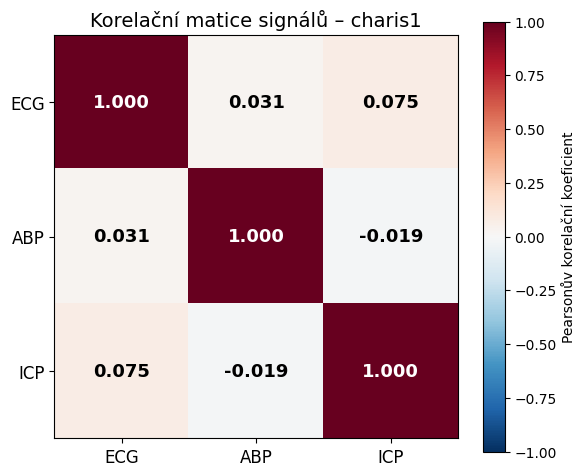

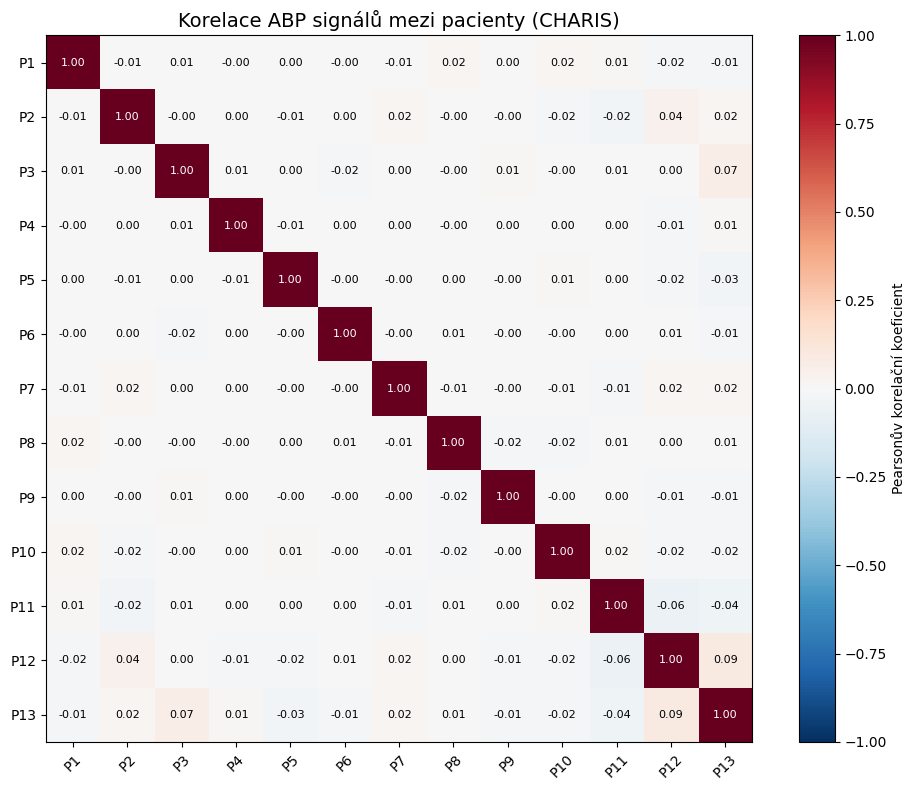


Korelační matice ABP signálů mezi pacienty:
          charis1  charis2  charis3  charis4  charis5  charis6  charis7  charis8  charis9  charis10  charis11  charis12  charis13
charis1    1.0000  -0.0054   0.0067  -0.0024   0.0034  -0.0038  -0.0076   0.0174   0.0038    0.0181    0.0135   -0.0151   -0.0132
charis2   -0.0054   1.0000  -0.0004   0.0024  -0.0065   0.0020   0.0159  -0.0045  -0.0044   -0.0177   -0.0245    0.0436    0.0217
charis3    0.0067  -0.0004   1.0000   0.0052   0.0032  -0.0158   0.0024  -0.0042   0.0119   -0.0001    0.0061    0.0017    0.0689
charis4   -0.0024   0.0024   0.0052   1.0000  -0.0071   0.0040   0.0001  -0.0039   0.0016    0.0042    0.0000   -0.0133    0.0114
charis5    0.0034  -0.0065   0.0032  -0.0071   1.0000  -0.0015  -0.0034   0.0038  -0.0010    0.0094    0.0034   -0.0181   -0.0255
charis6   -0.0038   0.0020  -0.0158   0.0040  -0.0015   1.0000  -0.0049   0.0054  -0.0037   -0.0008    0.0027    0.0067   -0.0144
charis7   -0.0076   0.0159   0.0024   0.0001 

In [5]:
def nacist_charis_signaly(jmeno, max_sekund=3600):
    cesta = os.path.join(CHARIS_DB, jmeno)
    hlavicka = wfdb.rdheader(cesta)
    fs = float(hlavicka.fs)
    limit = min(hlavicka.sig_len, int(max_sekund * fs)) # centralizovano, na prvni hodinu
    zaznam = wfdb.rdrecord(cesta, sampto=limit)

    signaly = {}
    for i, nazev in enumerate(zaznam.sig_name):
        sig = zaznam.p_signal[:, i].astype(float)
        nans = np.isnan(sig)
        if np.any(nans):
            x = np.arange(len(sig))
            sig[nans] = np.interp(x[nans], x[~nans], sig[~nans])
        signaly[nazev] = centrovat(sig)

    return signaly, fs

def pearson_korelace(x, y):
    mx, my = np.mean(x), np.mean(y)
    sx = np.sqrt(np.sum((x - mx)**2))
    sy = np.sqrt(np.sum((y - my)**2))
    if sx == 0 or sy == 0:
        return 0.0
    return np.sum((x - mx) * (y - my)) / (sx * sy)

zaznamy_charis = [f'charis{i}' for i in range(1, 14)]

for jmeno in zaznamy_charis:
    h = wfdb.rdheader(os.path.join(CHARIS_DB, jmeno))
    print(f"  {jmeno}: Fs = {h.fs} Hz, kanály: {h.sig_name}")
print("Všechny záznamy = 50 Hz, převzorkování není potřeba.\n")

pary = [('ECG', 'ABP'), ('ECG', 'ICP'), ('ABP', 'ICP')]
data_pacienti = {}
radky_kor = []

for jmeno in zaznamy_charis:
    signaly, fs_ch = nacist_charis_signaly(jmeno)
    data_pacienti[jmeno] = signaly

    radek = {'Pacient': jmeno}
    for s1, s2 in pary:
        radek[f'{s1}–{s2}'] = round(pearson_korelace(signaly[s1], signaly[s2]), 4)
    radky_kor.append(radek)

df_kor = pd.DataFrame(radky_kor)
print("Korelace mezi signály u jednotlivých pacientů (1. hodina):")
print(df_kor.to_string(index=False))

ukazka = 'charis1'
sig_jmena = ['ECG', 'ABP', 'ICP']
matice_uk = np.array([[pearson_korelace(data_pacienti[ukazka][s1],
                                         data_pacienti[ukazka][s2])
                        for s2 in sig_jmena] for s1 in sig_jmena])

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(matice_uk, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(sig_jmena, fontsize=12)
ax.set_yticklabels(sig_jmena, fontsize=12)
for i in range(3):
    for j in range(3):
        ax.text(j, i, f'{matice_uk[i,j]:.3f}', ha='center', va='center',
                fontsize=13, fontweight='bold',
                color='white' if abs(matice_uk[i,j]) > 0.5 else 'black')
plt.colorbar(im, ax=ax, label='Pearsonův korelační koeficient')
plt.title(f'Korelační matice signálů – {ukazka}', fontsize=14)
plt.tight_layout()
plt.show()

# Zarovnání podle dominantního vrcholu v prvních 5 s
zarovnane_abp = {}
min_delka = float('inf')

for jmeno in zaznamy_charis:
    abp = data_pacienti[jmeno]['ABP']
    pik = np.argmax(abp[:int(5 * 50)])
    zarovnane_abp[jmeno] = centrovat(abp[pik:])
    min_delka = min(min_delka, len(zarovnane_abp[jmeno]))

for jmeno in zarovnane_abp:
    zarovnane_abp[jmeno] = zarovnane_abp[jmeno][:min_delka]

n_pac = len(zaznamy_charis)
matice_abp = np.zeros((n_pac, n_pac))
for i in range(n_pac):
    for j in range(n_pac):
        matice_abp[i, j] = pearson_korelace(
            zarovnane_abp[zaznamy_charis[i]], zarovnane_abp[zaznamy_charis[j]])

kratke = [j.replace('charis', 'P') for j in zaznamy_charis]
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(matice_abp, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(n_pac))
ax.set_yticks(range(n_pac))
ax.set_xticklabels(kratke, rotation=45, fontsize=10)
ax.set_yticklabels(kratke, fontsize=10)
for i in range(n_pac):
    for j in range(n_pac):
        ax.text(j, i, f'{matice_abp[i,j]:.2f}', ha='center', va='center',
                fontsize=8, color='white' if abs(matice_abp[i,j]) > 0.5 else 'black')
plt.colorbar(im, ax=ax, label='Pearsonův korelační koeficient')
plt.title('Korelace ABP signálů mezi pacienty (CHARIS)', fontsize=14)
plt.tight_layout()
plt.show()

df_abp_kor = pd.DataFrame(matice_abp, index=zaznamy_charis,
                           columns=zaznamy_charis).round(4)
print("\nKorelační matice ABP signálů mezi pacienty:")
print(df_abp_kor.to_string())